# ASL Classification with a CNN

In [6]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-rhzdpz7v
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-rhzdpz7v
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0-cp36-none-any.whl size=82437 sha256=0710903e974afa52bb3a61ec13b4f3ea2cc594f03f43527443acd7bda9fed5ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-8sf5hfn4/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import numpy as np
#import keras

from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from glob import glob


# Get reproducible results
random_state = 46
tf.random.set_seed(random_state)

## GPU configuration
If you have a GPU, enable experimental memory growth.

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## File Paths

In [9]:
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/ECE 542/asl_alphabet_test"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
asl_alphabet_test


In [0]:
train_dir = "/content/drive/My Drive/ECE 542/asl_alphabet_train/asl_alphabet_train"
test_dir = "/content/drive/My Drive/ECE 542/asl_alphabet_test/asl_alphabet_test"
test_dir_rasband = "/content/drive/My Drive/ECE 542/asl_alphabet_rasbandtest"
best_model_path = "/content/drive/My Drive/ECE 542/VGG16_64px_bestValAccuracy.h5"

classnames = [folder[len(train_dir) + 1:] for folder in glob(train_dir + '/*')]
classnames.sort()

## Train model

In [0]:
def fit_model(model, train_generator, val_generator):
    sel_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=sel_optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.summary()
    
    print('Fitting model...')
    history = model.fit(train_generator, 
        steps_per_epoch=50, 
        epochs=45, 
        verbose=1, 
        validation_data=val_generator, 
        validation_steps=5,
        use_multiprocessing=False,
        workers=8,
        callbacks=[
                tf.keras.callbacks.ModelCheckpoint(filepath=best_model_path, monitor='val_accuracy', save_best_only = True),
                tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience = 3, restore_best_weights = True)
            ])
    
    print('Evaluating model...')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    
    del model
    K.clear_session()

   

# Base models

## VGG16
This model uses VGG16 as a base model initialized with the ImageNet weights.  

In [16]:
imagesize = 64

datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    brightness_range = (0.25,1.75),
    rotation_range=20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    validation_split=0.20)

testdatagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.0)

train_generator = datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(imagesize, imagesize),
    batch_size=128,
    class_mode='sparse',
)

val_generator = datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(imagesize, imagesize),
    batch_size=128,
    class_mode='sparse',
)

base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
for layer in base_model.layers[:-3]:
            layer.trainable = False

Found 69632 images belonging to 29 classes.
Found 17404 images belonging to 29 classes.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65536     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 29)                3741      
Total params: 14,784,477
Trainable params: 4,789,149
Non-trainable params: 9,995,328
___________________________________

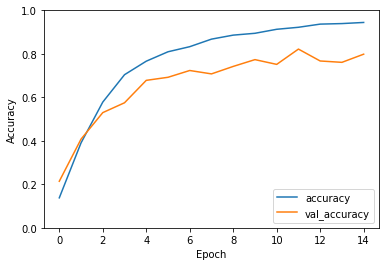

In [17]:
fit_model(tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(29)
]), train_generator, val_generator)

In [18]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import itertools

model_path = best_model_path

model_uploaded = load_model(model_path)

test_generator = testdatagen.flow_from_directory(
    test_dir_rasband,
    target_size=(imagesize, imagesize),
    class_mode='sparse',
    batch_size = 1,
    shuffle=False
)


model_uploaded.evaluate(test_generator, verbose=1,steps=870)

predictions = model_uploaded.predict(test_generator, verbose = 1, steps = 870)

y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
predDict = dict(y_pred=y_pred, y_true=y_true)

print(classification_report(**predDict, target_names=classnames))





/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Found 870 images belonging to 29 classes.
870/870 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

           A       0.07      0.03      0.04        30
           B       0.07      0.10      0.08        30
           C       0.60      0.10      0.17        30
           D       0.28      0.30      0.29        30
           E       0.29      0.13      0.18        30
           F       0.32      0.20      0.24        30
           G       0.06      0.03      0.04        30
           H       0.40      0.53      0.46        30
           I       0.55      0.37      0.44        30
           J       0.43      0.53      0.48        30
           K       0.25      0.40      0.31        30
           L       0.19      0.33      0.24        30
           M       0.16      0.50      0.24        30
           N       0.22      0.50      0.31        30
           O       0.65      0.57      0.61        30
           P       0.45      0.63     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization


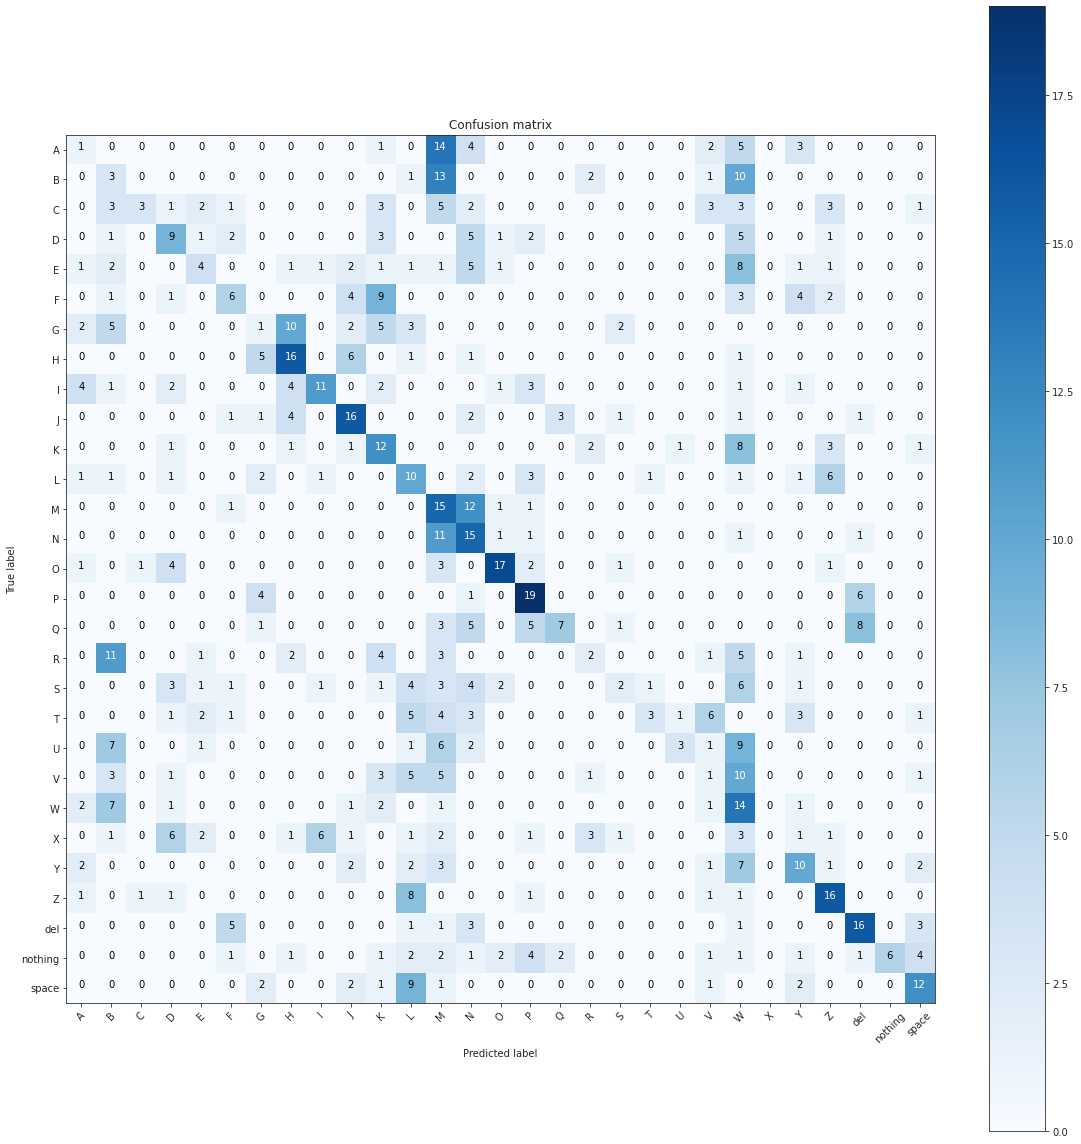

In [19]:
def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    '''
    Plot a confusion matrix heatmap using matplotlib. This code was obtained from
    the scikit-learn documentation:

    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return

def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(16, 16))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

with sns.axes_style('ticks'):
    plot_confusion_matrix_with_default_options(**predDict, classes=classnames)